<img src="./images/QISKit-c.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="250 px" align="left">

## _*Single-qubit Quantum Random Access Coding (QRAC)*_ 


***
### Contributors
Rudy Raymond, Takashi Imamichi

## Introduction

Random Access Coding (RAC) is one of few examples where a small number of quantum bits can exhibit properties that cannot be achieved by the same amount of classical bits. To demonstrate the power of Quantum RAC with a single qubit, consider a case where the sender, say, Alice, wants to encode $n$ bits of information into a qubit. The qubit is then sent to the receiver, say, Bob, who will decode it to obtain one bit (out of $n$ bits sent by Alice) of his choice (which is unknown to Alice). It is known that there is no way for Alice to encode her $2$ bits into one classical bit so that Bob can then recover any bit with success probability better than half. 

On the other hand, with a single qubit it is possible to encode up to $3$ bits of information such that the receiver is quaranteed to observe his choice of bit with probability better than random guessing. The encoding and decoding scheme for encoding 2 bits and 3 bits of information into 1 qubit are denoted as, respectively, $(2,1)$-QRAC and $(3,1)$-QRAC.   

Here, we describe how to construct the $(2,1)$-QRAC, i.e., encoding $2$ bits of information into $1$ qubit so that any bit can be recovered with probability at least $0.85$, as well as the $(3,1)$-QRAC, i.e., encoding $3$-bits of information into $1$ qubit so that any bit can be recovered with probability at least $0.78$ by using single qubit unitary gates and measurements. All unitary gates and measurements can be realized by the $u3$ rotation gates included in the [qelib1.inc](https://github.com/IBM/qiskit-openqasm/blob/master/examples/qelib1.inc) whose mathematical definition can be found [here](https://github.com/IBM/qiskit-openqasm/blob/master/spec/qasm2.pdf).

First, as usual we prepare the environment.

In [1]:
import sys
if sys.version_info < (3,0):
    raise Exception("Please use Python version 3 or greater.")


import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.linalg
%matplotlib inline
import time

from IBMQuantumExperience import IBMQuantumExperience
import Qconfig
from qhelpers.basicplotter import plot_histogram
from qhelpers.misc import get_data
from qhelpers.misc import combine_jobs
from qhelpers.misc import average_data


api = IBMQuantumExperience.IBMQuantumExperience(Qconfig.APItoken,Qconfig.config)

## Encoding 2 bits into 1 qubit with $(2,1)$-QRAC
We follow Example 1 described in the paper [here](http://iopscience.iop.org/article/10.1088/1367-2630/8/8/129/meta). Alice encodes her $2$ bits $x_1x_2$ by preparing the following 1-qubit states $\left|\phi_{x_1x_2}\right>$.
\begin{eqnarray}
\left|\phi_{00}\right> &=& \cos\left(\pi/8\right)\left|0\right> + \sin\left(\pi/8\right)\left|1\right>\\
\left|\phi_{10}\right> &=& \cos\left(3\pi/8\right)\left|0\right> + \sin\left(3\pi/8\right)\left|1\right>\\
\left|\phi_{11}\right> &=& \cos\left(5\pi/8\right)\left|0\right> + \sin\left(5\pi/8\right)\left|1\right>\\
\left|\phi_{01}\right> &=& \cos\left(7\pi/8\right)\left|0\right> + \sin\left(7\pi/8\right)\left|1\right>\\
\end{eqnarray}

Bob recovers his choice of bit by measuring the qubit in the following way. If he wants to recover the first bit (i.e., $x_1$), he measures the qubit in the $\left\{\left|0\right>, \left|1\right>\right\}$ basis, namely, he concludes $0$ if he observes $\left|0\right>$, and $1$ otherwise. On the other hand, if he wants to recover the second bit (i.e., $x_2$), he measures the qubit in the $\left\{\left|+\right>, \left|-\right>\right\}$ basis, where $\left|+\right> = 1/\sqrt{2}\left(\left|0\right> + \left|1\right>\right)$, and $\left|-\right> = 1/\sqrt{2}\left(\left|0\right> - \left|1\right>\right)$. 

Below is the QASM source of gates for decoding and encoding of $(2,1)$-QRAC along with examples encoding $10$ and measuring the qubit to obtain the first bit on the simulator. Notice that because in the IBMQuantumExperience we can only perform measurement in the $\left\{\left|0\right>, \left|1\right>\right\}$ basis, the measurement in the $\left\{\left|+\right>, \left|-\right>\right\}$ basis is performed by first applying the Hadamard gate.  

status = {'RUNNING': 1} (0 seconds)
status = {'RUNNING': 1} (2 seconds)
status = {'COMPLETED': 1} (4 seconds)


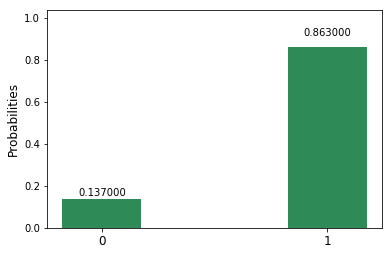

In [2]:
qrac21="""
OPENQASM 2.0;
include "qelib1.inc";
//(2,1)-QRAC encoding for 00
gate encode00 q
{
  u3(pi/4,0,0) q;
}

//(2,1)-QRAC encoding for 10
gate encode10 q
{
  u3(3*pi/4,0,0) q;
}

//(2,1)-QRAC encoding for 11
gate encode11 q
{
  u3(5*pi/4,0,0) q;
}

//(2,1)-QRAC encoding for 01
gate encode01 q
{
  u3(7*pi/4,0,0) q;
}

//(2,1)-QRAC decoding for the first bit
gate decodeFirst q
{
  id q;
}

//(2,1)-QRAC decoding for the second bit
gate decodeSecond q
{
  h q;
}

//example of encoding 10 and measuring the first
qreg q[1];
creg c[1];

encode10 q[0];
barrier q[0]; //barrier for emphasizing the difference the encoding and decoding
decodeFirst q[0];
measure q[0] -> c[0];
"""
qasms = [{'qasm' : qrac21}]
out = api.run_job(qasms=qasms,device='simulator',shots=1000,max_credits=3)
jobids=[out['id']]
results=combine_jobs(jobids, api, wait=2, timeout=240)
data=get_data(results,0)
plot_histogram(data)

From the above simulation, we can see that the first bit is decoded with probability closed to the theoretical value. We can perform various experiments of $(2,1)$-QRAC on the simulator by the above code: encoding any two bits and decoding any bit (first or second as counted from left to right) by, respectively, adjusting the line ```encode10 q[0];``` and the line ```decodeFirst q[0]```. 

We can also run an equivalent code on the real IBM Q and obtain similar success probability as predicted by the theory. Notice that because as of March 2017 it does not support the `gate` syntax, we rewrite the above code as follows.

In [ ]:
qrac21="""
// qasm/qrac2_1.qasm
OPENQASM 2.0;
include "qelib1.inc";
qreg q[1];
creg c[1];

// change the coefficient of pi/4 for different bit patterns
// 1: 00
// 7: 01
// 3: 10
// 5: 11
u3(3*pi/4,0,0) q;

// change the gate to extract a particular bit
// id q[0]: first bit
// h q[0]: second bit
id q[0];
measure q -> c;
"""
qasms = [{'qasm' : qrac21}]
out = api.run_job(qasms=qasms,device='qx5q',shots=1000,max_credits=3)
jobids=[out['id']]
results=combine_jobs(jobids, api, wait=2, timeout=240)
data=get_data(results,0)
plot_histogram(data)

## Encoding 3 bits into 1 qubit with $(3,1)$-QRAC
We follow Example 2 described in the paper [here](http://iopscience.iop.org/article/10.1088/1367-2630/8/8/129/meta). 
Alice encodes her $3$ bits $x_1x_2x_3$ by preparing the following 1-qubit states $\left|\phi_{x_1x_2x_3}\right>$ as below, where $\cos^2\left(\theta\right) = 1/2 + \sqrt{3}/6 > 0.788$.   

\begin{eqnarray}
\left|\phi_{000}\right> &=& \cos\left(\theta\right)\left|0\right> + e^{i\pi/4}\sin\left(\theta\right)\left|1\right>\\
\left|\phi_{001}\right> &=& \cos\left(\theta\right)\left|0\right> + e^{-i\pi/4}\sin\left(\theta\right)\left|1\right>\\
\left|\phi_{010}\right> &=& \cos\left(\theta\right)\left|0\right> + e^{3i\pi/4}\sin\left(\theta\right)\left|1\right>\\
\left|\phi_{011}\right> &=& \cos\left(\theta\right)\left|0\right> + e^{-3i\pi/4}\sin\left(\theta\right)\left|1\right>\\
\left|\phi_{100}\right> &=& \sin\left(\theta\right)\left|0\right> + e^{i\pi/4}\cos\left(\theta\right)\left|1\right>\\
\left|\phi_{101}\right> &=& \sin\left(\theta\right)\left|0\right> + e^{-i\pi/4}\cos\left(\theta\right)\left|1\right>\\
\left|\phi_{110}\right> &=& \sin\left(\theta\right)\left|0\right> + e^{3i\pi/4}\cos\left(\theta\right)\left|1\right>\\
\left|\phi_{111}\right> &=& \sin\left(\theta\right)\left|0\right> + e^{-i\pi/4}\cos\left(\theta\right)\left|1\right>\\
\end{eqnarray}

Bob recover his choice of bit by measuring the qubit similarly as in the $(2,1,0.85)$-QRAC for the first and second bit, and to recover the third bit, he measures the qubit in the $\left\{\left|+'\right>, \left|-'\right>\right\}$ basis, where $\left|+'\right> = 1/\sqrt{2}\left(\left|0\right> + i \left|1\right>\right)$, and $\left|-'\right> = 1/\sqrt{2}\left(\left|0\right> - i \left|1\right>\right)$. 

Intuitively, the encoding of $(3,1)$-QRAC correspond to assigning the $8$ states to the corners of the unit cube inside the Bloch Sphere as depicted in the figure below. 
<img src="./images/blochsphere31.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="300 px" align="center">

Below is the QASM source of gates for decoding and encoding of $(3,1)$-QRAC along with examples encoding $101$ and measuring the qubit to obtain the first bit that can be run on the simulator of IBM Q. We can see that the first bit is recovered with probability closed to that predicted by the theory. 

status = {'RUNNING': 1} (0 seconds)
status = {'RUNNING': 1} (2 seconds)
status = {'COMPLETED': 1} (4 seconds)


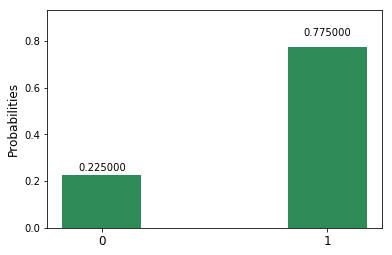

In [3]:
qrac31="""
OPENQASM 2.0;
include "qelib1.inc";
//(3,1)-QRAC encoding for 000
gate encode000 q
{
  u3(2*0.152043362*pi, pi/4, -pi/4) q;
}

//(3,1)-QRAC encoding for 010
gate encode010 q
{
  u3(2*0.152043362*pi, 3*pi/4, -3*pi/4) q;
}

//(3,1)-QRAC encoding for 100
gate encode100 q
{
  u3(pi-2*0.152043362*pi, pi/4, -pi/4) q;
}

//(3,1)-QRAC encoding for 110
gate encode110 q
{
  u3(pi-2*0.152043362*pi, 3*pi/4, -3*pi/4) q;
}

//(3,1)-QRAC encoding for 001
gate encode001 q
{
  u3(2*0.152043362*pi, -pi/4, pi/4) q;
}

//(3,1)-QRAC encoding for 011
gate encode011 q
{
  u3(2*0.152043362*pi, -3*pi/4, 3*pi/4) q;
}

//(3,1)-QRAC encoding for 101
gate encode101 q
{
  u3(pi-2*0.152043362*pi, -pi/4, pi/4) q;
}

//(3,1)-QRAC encoding for 111
gate encode111 q
{
  u3(pi-2*0.152043362*pi, -3*pi/4, 3*pi/4) q;
}

//(3,1)-QRAC decoding for the first bit
gate decodeFirst q
{
  id q;
}

//(3,1)-QRAC decoding for the second bit
gate decodeSecond q
{
  h q;
}

//(3,1)-QRAC decoding for the third bit
gate decodeThird q
{
  u3(pi/2, -pi/2, pi/2) q;
}

//example of encoding 101 and measuring the first
qreg q[1];
creg c[1];

encode101 q[0];
barrier q[0];
decodeFirst q[0];
measure q[0] -> c[0];
"""
qasms = [{'qasm' : qrac31}]
out = api.run_job(qasms=qasms,device='simulator',shots=1000,max_credits=3)
jobids=[out['id']]
results=combine_jobs(jobids, api, wait=2, timeout=240)
data=get_data(results,0)
plot_histogram(data)

Similarly as before, we can run an equivalent code without the `gate` syntax on the real IBM Q, and observe that the bit of interest is retrieved with probability closed to that from the simulation.

In [ ]:
qrac31="""
// qasm/qrac3_1.qasm
OPENQASM 2.0;
include "qelib1.inc";
qreg q[1];
creg c[1];

//example of encoding 101 and measuring the first bit

//(3,1)-QRAC encoding
//
//u3(2*0.152043362*pi, pi/4, -pi/4) q;          // 000
//u3(2*0.152043362*pi, 3*pi/4, -3*pi/4) q;      // 010
//u3(pi-2*0.152043362*pi, pi/4, -pi/4) q;       // 100
//u3(pi-2*0.152043362*pi, 3*pi/4, -3*pi/4) q;   // 110
//u3(2*0.152043362*pi, -pi/4, pi/4) q;          // 001
//u3(2*0.152043362*pi, -3*pi/4, 3*pi/4) q;      // 011
u3(pi-2*0.152043362*pi, -pi/4, pi/4) q;       // 101
//u3(pi-2*0.152043362*pi, -3*pi/4, 3*pi/4) q;   // 111

//(3,1)-QRAC decoding
//
id q;                     // first bit
//h q;                      // second bit
//u3(pi/2, -pi/2, pi/2) q;  // third bit

measure q -> c;

"""
qasms = [{'qasm' : qrac31}]
out = api.run_job(qasms=qasms,device='qx5q',shots=1000,max_credits=3)
jobids=[out['id']]
results=combine_jobs(jobids, api, wait=2, timeout=240)
data=get_data(results,0)
plot_histogram(data)

## About Quantum Random Access Coding
The notion of Quantum RAC was first presented [here](https://arxiv.org/abs/quant-ph/9804043) along with the concrete example of $(2,1)$-QRAC which apparently was discovered much earlier in 1983 by [Wiesner](http://dl.acm.org/citation.cfm?doid=1008908.1008920). The idea of the $(3,1)$-QRAC appeared in the [classic book of Mike and Ike](https://www.amazon.com/Quantum-Computation-Information-10th-Anniversary/dp/1107002176). The first experiments on $(2,1)$-QRAC and $(3,1)$-QRAC were presented [here](https://arxiv.org/abs/0805.1463). It is not possible to perform $(4,1)$-QRAC as shown [here](http://iopscience.iop.org/article/10.1088/1367-2630/8/8/129/meta).  